In [1]:
import mne
import os
from mne.preprocessing import create_eog_epochs, EOGRegression
from mne.preprocessing import (
    compute_proj_ecg,
    compute_proj_eog,
    create_ecg_epochs,
    create_eog_epochs,
)
import h5py
import numpy as np
import pandas as pd


In [2]:
def mkraw_task_test(subject_id, tasktime, interpolate_bad_channels, highpass):
    # read the EEG data
    eeg_path = os.path.join('..', '..', '..', 'data', str(subject_id), str(subject_id) + '_' + str(tasktime) + '_withevent.mat')
    # eeg_data = loadmat(eeg_path)['eeg']
    # eeg_data[1:33] *= 1e-6 # convert to microvolts, including 31 eeg channels and 1 eog channel
    # Open the MATLAB v7.3 file using h5py
    with h5py.File(eeg_path, 'r') as file:
        eeg_data = np.array(file['eeg']).T  # Transpose might be needed based on data organization
        eeg_data[1:33] *= 1e-6  # convert to microvolts, including 31 eeg channels and 1 eog channel

    # get placement data of standard 10-20 system
    montage_1020 = mne.channels.make_standard_montage('standard_1020')
    positions_1020 = montage_1020._get_ch_pos()
    elec_coords_1020 = {ch_name: coord for ch_name, coord in positions_1020.items() if ch_name in montage_1020.ch_names}

    # Define channel names and types
    ch_names = ['Time'] + ['Fp1', 'Fp2', 
                        'AF3', 'AF4', 
                        'F7', 'F3', 'Fz', 'F4', 'F8',
                        'FC5', 'FC1', 'FC2', 'FC6',
                        'T7', 'C3', 'Cz', 'C4', 'T8',
                        'CP5', 'CP1', 'CP2', 'CP6',
                        'P7', 'P3', 'Pz', 'P4', 'P8',
                        'PO3', 'PO4',
                        'O1', 'O2'] + ['EOG'] + ['Trigger'] + ['rest', 'question', 'response']
    ch_types = ['misc'] + ['eeg'] * 31 + ['eog'] + ['misc'] + ['stim'] * 3

    # Create the info object
    info = mne.create_info(ch_names, sfreq=4800, ch_types=ch_types)
    # Create raw object
    raw = mne.io.RawArray(eeg_data, info)

    # manually add the placement of electrodes
    elec_coords = {
        'Fp1': elec_coords_1020['Fp1'],
        'Fp2': elec_coords_1020['Fp2'],
        'AF3': elec_coords_1020['AF3'],
        'AF4': elec_coords_1020['AF4'],
        'F7': elec_coords_1020['F7'],
        'F3': elec_coords_1020['F3'],
        'Fz': elec_coords_1020['Fz'],
        'F4': elec_coords_1020['F4'],
        'F8': elec_coords_1020['F8'],
        'FC5': elec_coords_1020['FC5'],
        'FC1': elec_coords_1020['FC1'],
        'FC2': elec_coords_1020['FC2'],
        'FC6': elec_coords_1020['FC6'],
        'T7': elec_coords_1020['T7'],
        'C3': elec_coords_1020['C3'],
        'Cz': elec_coords_1020['Cz'],
        'C4': elec_coords_1020['C4'],
        'T8': elec_coords_1020['T8'],
        'CP5': elec_coords_1020['CP5'],
        'CP1': elec_coords_1020['CP1'],
        'CP2': elec_coords_1020['CP2'],
        'CP6': elec_coords_1020['CP6'],
        'P7': elec_coords_1020['P7'],
        'P3': elec_coords_1020['P3'],
        'Pz': elec_coords_1020['Pz'],
        'P4': elec_coords_1020['P4'],
        'P8': elec_coords_1020['P8'],
        'PO3': elec_coords_1020['PO3'],
        'PO4': elec_coords_1020['PO4'],
        'O1': elec_coords_1020['O1'],
        'O2': elec_coords_1020['O2'],
    }

    # Create the montage object
    montage = mne.channels.make_dig_montage(elec_coords, coord_frame='head')

    # add info and montage to raw object
    raw.set_montage(montage)
    raw.info['subject_info'] = {'id': subject_id}
    raw.info['experimenter'] = 'pre-task' if tasktime == 1 else 'post-task'

    # preprocess the data
    # highpass filter
    raw.filter(highpass, None, picks=['eeg', 'eog'])
    raw.notch_filter(freqs=np.arange(100, 251, 50), picks=['eeg'], notch_widths=np.arange(100, 251, 50)/50)


    # mark bad channels
    if interpolate_bad_channels:
        bad_channels_df = pd.read_csv('bad_channels.csv')
        bad_channels_row = bad_channels_df[(bad_channels_df['subject id'] == subject_id) & (bad_channels_df['session'] == 'task') & (bad_channels_df['task time'] == ('pre' if tasktime == 1 else 'post'))]
        if not bad_channels_row.empty:
            bad_channels = bad_channels_row['bad channels'].values[0]
            if pd.notna(bad_channels):
                bad_channels_list = bad_channels.split(',')
                raw.info['bads'].extend(bad_channels_list)

    # # handle EOG
    # eog_picks = mne.pick_types(raw.info, meg=False, eeg=True, eog=True)
    # eog_evoked = create_eog_epochs(raw, picks=eog_picks).average()
    # eog_evoked.apply_baseline((None, None))
    # eog_projs, _ = compute_proj_eog(raw, n_grad=0, n_mag=0, n_eeg=1, reject=None, no_proj=True)
    # raw.add_proj(eog_projs).apply_proj()
    
    # re-reference
    raw.set_eeg_reference('average', projection=False)

    # interpolate
    if interpolate_bad_channels:
        # Interpolate bad channels
        if raw.info['bads']:
            raw.interpolate_bads(reset_bads=True) # remove the bads from info.
        print(bad_channels)
    
    # notch filter q=50, notch_widths = freq/q
    # raw.notch_filter(50, notch_widths=1)
    # raw.notch_filter(100, notch_widths=2)
    print('subject id: ' + str(subject_id) + ' tasktime: pre-task. DONE.' if tasktime == 1 else 'subject id: ' + str(subject_id) + ' tasktime: post-task. DONE.')
    raw_save_path = os.path.join('..', '..', '..', 'data', str(subject_id), 'test_raw_' + str(subject_id) + '_' + str(tasktime) + '.fif')
    raw.save(raw_save_path, overwrite=True)

    # fig = mne.viz.plot_raw_psd(raw, fmax=150, spatial_colors=True)
    # plot_save_path = os.path.join('..', '..', '..', 'data', 'psd', str(subject_id) + '_' + before_or_after + '.png')
    # fig.savefig(plot_save_path)

mkraw_task_test(19, 1, interpolate_bad_channels=True, highpass=0.3)

Creating RawArray with float64 data, n_channels=37, n_times=5421607
    Range : 0 ... 5421606 =      0.000 ...  1129.501 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.3 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.30
- Lower transition bandwidth: 0.30 Hz (-6 dB cutoff frequency: 0.15 Hz)
- Filter length: 52801 samples (11.000 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    3.7s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 31681 samples (6.600 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    3.8s


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
nan
subject id: 19 tasktime: pre-task. DONE.
Overwriting existing file.
Writing c:\Users\Tianyi Zheng\OneDrive - neuron.t.u-tokyo.ac.jp\Documents\zheng\mywork\intelligence_tRNS\tRNS-Intelligence\processing\prepare_raw_file\..\..\..\data\19\test_raw_19_1.fif


C:\Users\Tianyi Zheng\AppData\Local\Temp\ipykernel_32408\765634263.py:114: RuntimeWarning: This filename (c:\Users\Tianyi Zheng\OneDrive - neuron.t.u-tokyo.ac.jp\Documents\zheng\mywork\intelligence_tRNS\tRNS-Intelligence\processing\prepare_raw_file\..\..\..\data\19\test_raw_19_1.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw.save(raw_save_path, overwrite=True)


Closing c:\Users\Tianyi Zheng\OneDrive - neuron.t.u-tokyo.ac.jp\Documents\zheng\mywork\intelligence_tRNS\tRNS-Intelligence\processing\prepare_raw_file\..\..\..\data\19\test_raw_19_1.fif
[done]


In [15]:
# load raw
subject_id = 19
tasktime = 1 # 1-pre, 2-post
raw_path = os.path.join('..', '..', '..', 'data', str(subject_id), 'test_raw_' + str(subject_id) + '_' + str(tasktime) + '.fif')
raw = mne.io.read_raw_fif(raw_path, preload=True)

Opening raw data file ..\..\..\data\19\test_raw_19_1.fif...
    Range : 0 ... 5421606 =      0.000 ...  1129.501 secs
Ready.
Reading 0 ... 5421606  =      0.000 ...  1129.501 secs...


C:\Users\Tianyi Zheng\AppData\Local\Temp\ipykernel_32408\2582913983.py:5: RuntimeWarning: This filename (..\..\..\data\19\test_raw_19_1.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(raw_path, preload=True)


In [16]:
# Pick EEG and EOG channels
raw.pick_types(eeg=True, eog=True, exclude=[])

# Set EEG reference and filter data
# raw.set_eeg_reference('average')
# Highpass filter to eliminate slow drifts
# raw.filter(0.3, None, picks= ['eeg', 'eog'])

# raw.plot(title="Before")

# Create EOG epochs
eog_evoked = create_eog_epochs(raw).average(picks="all")
eog_evoked.apply_baseline((None, None))
# eog_evoked.plot_joint()
eog_projs, _ = compute_proj_eog(
    raw, n_grad=1, n_mag=1, n_eeg=1, reject=None, no_proj=True
)

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Using EOG channel: EOG
EOG channel index for this subject is: [31]
Filtering the data to remove DC offset to help distinguish blinks from saccades
Selecting channel EOG for blink detection
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 48000 samples (10.000 s)

Now detecting blinks and generating corresponding events
Found 208 significant peaks
Number of EOG events detected: 208
Not setting metadata
208 matching events found
No baseline correction applied
Using data from preloaded Raw for 208 events and 4

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    5.5s


Not setting metadata
208 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 208 events and 1921 original time points ...
0 bad epochs dropped
No channels 'grad' found. Skipping.
No channels 'mag' found. Skipping.
Adding projection: eeg--0.200-0.200-PCA-01
Done.


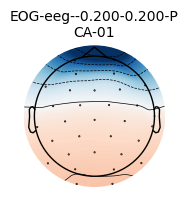

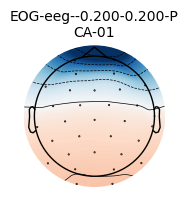

In [12]:
mne.viz.plot_projs_topomap(eog_projs, info=raw.info)

1 projection items deactivated


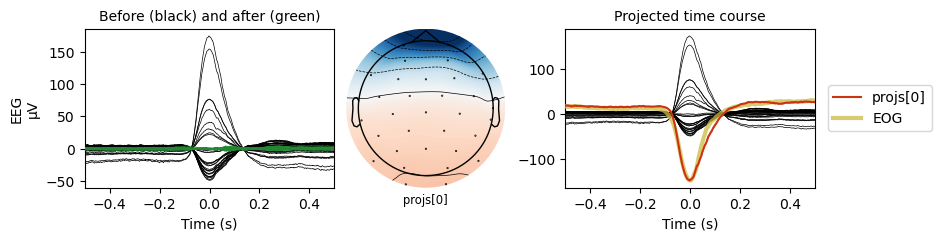

In [7]:
fig = mne.viz.plot_projs_joint(eog_projs, eog_evoked, "eog")
fig.suptitle("EOG projectors (1 SSP vector)")

fig.savefig('../../../paper/preprocessing/EOG_oneproj.png', dpi=600)

Opening raw data file ..\..\..\data\19\test_raw_19_1.fif...
    Range : 0 ... 5421606 =      0.000 ...  1129.501 secs
Ready.
Reading 0 ... 5421606  =      0.000 ...  1129.501 secs...


C:\Users\Tianyi Zheng\AppData\Local\Temp\ipykernel_32408\3019383132.py:5: RuntimeWarning: This filename (..\..\..\data\19\test_raw_19_1.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(raw_path, preload=True)


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Using EOG channel: EOG
EOG channel index for this subject is: [31]
Filtering the data to remove DC offset to help distinguish blinks from saccades
Selecting channel EOG for blink detection
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 48000 samples (10.000 s)

Now detecting blinks and generating corresponding events
Found 208 significant peaks
Number of EOG events detected: 208
Not setting metadata
208 matching events found
No baseline correction applied
Using data from preloaded Raw for 208 events and 4

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    5.6s


Not setting metadata
208 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 208 events and 1921 original time points ...
0 bad epochs dropped
No channels 'grad' found. Skipping.
No channels 'mag' found. Skipping.
Adding projection: eeg--0.200-0.200-PCA-01
Adding projection: eeg--0.200-0.200-PCA-02
Done.
2 projection items deactivated


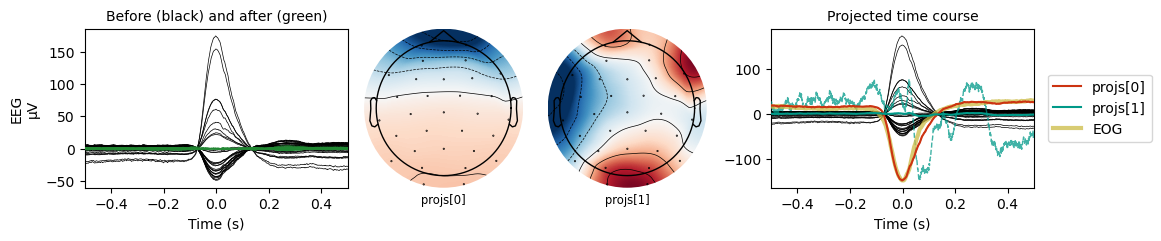

In [9]:
# load raw
subject_id = 19
tasktime = 1 # 1-pre, 2-post
raw_path = os.path.join('..', '..', '..', 'data', str(subject_id), 'test_raw_' + str(subject_id) + '_' + str(tasktime) + '.fif')
raw = mne.io.read_raw_fif(raw_path, preload=True)

# Pick EEG and EOG channels
raw.pick_types(eeg=True, eog=True, exclude=[])

# Create EOG epochs
eog_evoked = create_eog_epochs(raw).average(picks="all")
eog_evoked.apply_baseline((None, None))
# eog_evoked.plot_joint()
eog_projs, _ = compute_proj_eog(
    raw, n_grad=1, n_mag=1, n_eeg=2, reject=None, no_proj=True
)

2 projection items deactivated


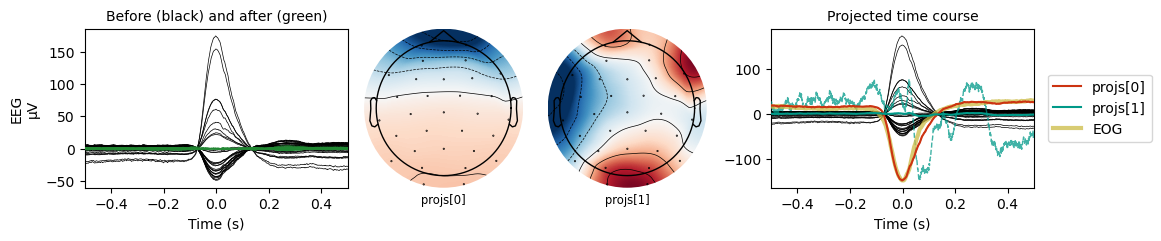

In [14]:
fig = mne.viz.plot_projs_joint(eog_projs, eog_evoked, "eog")
fig.suptitle("EOG projectors (2 SSP vectors)")

fig.savefig('../../../paper/preprocessing/EOG_twoproj.png', dpi=600)

In [ ]:
stop

In [126]:
raw.plot(title="Before")
eog_picks = mne.pick_types(raw.info, meg=False, eeg=True, eog=True)
eog_evoked = create_eog_epochs(raw, picks=eog_picks).average()
eog_evoked.apply_baseline((None, None))
eog_projs, _ = compute_proj_eog(raw, n_grad=0, n_mag=0, n_eeg=1, reject=None, no_proj=True)
raw.add_proj(eog_projs).apply_proj()
raw.plot(title="After")

Using EOG channel: EOG
EOG channel index for this subject is: [32]
Filtering the data to remove DC offset to help distinguish blinks from saccades
Selecting channel EOG for blink detection
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 48000 samples (10.000 s)

Now detecting blinks and generating corresponding events
Found 79 significant peaks
Number of EOG events detected: 79
Not setting metadata
79 matching events found
No baseline correction applied
Using data from preloaded Raw for 79 events and 4801 original time points ...
0 bad epochs dropped
Applying baseline correction (m

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    3.7s


Not setting metadata
79 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 79 events and 1921 original time points ...
0 bad epochs dropped
No channels 'grad' found. Skipping.
No channels 'mag' found. Skipping.
Adding projection: eeg--0.200-0.200-PCA-01
Done.
1 projection items deactivated
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...


In [127]:
stop

NameError: name 'stop' is not defined

In [ ]:
# Pick EEG and EOG channels
raw.pick_types(eeg=True, eog=True, exclude=[])

# Set EEG reference and filter data
raw.set_eeg_reference('average')
# Highpass filter to eliminate slow drifts
raw.filter(0.3, None, picks= ['eeg', 'eog'])

# Create EOG epochs
eog_epochs = create_eog_epochs(raw, ch_name='EOG', tmin=-0.5, tmax=0.5)  # This automatically detects EOG events
eog_epochs.apply_baseline((None, None))  # Baseline correction, if necessary

# Perform regression to get correction coefficients
model_plain = EOGRegression(picks="eeg", picks_artifact="eog").fit(eog_epochs)

raw.plot(title='Before')
raw_clean = model_plain.apply(raw)
# raw_clean.apply_baseline()
raw_clean.plot(title='After')

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.3 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.30
- Lower transition bandwidth: 0.30 Hz (-6 dB cutoff frequency: 0.15 Hz)
- Filter length: 52801 samples (11.000 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.2s


Using EOG channel: EOG
EOG channel index for this subject is: [31]
Filtering the data to remove DC offset to help distinguish blinks from saccades
Selecting channel EOG for blink detection
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 48000 samples (10.000 s)

Now detecting blinks and generating corresponding events
Found 79 significant peaks
Number of EOG events detected: 79
Not setting metadata
79 matching events found
No baseline correction applied
Using data from preloaded Raw for 79 events and 4801 original time points ...
0 bad epochs dropped
Applying baseline correction (m

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 0.3 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.30
- Lower transition bandwidth: 0.30 Hz (-6 dB cutoff frequency: 0.15 Hz)
- Filter length: 52801 samples (11.000 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    2.3s


Using EOG channel: EOG
EOG channel index for this subject is: [32]
Filtering the data to remove DC offset to help distinguish blinks from saccades
Selecting channel EOG for blink detection
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 48000 samples (10.000 s)

Now detecting blinks and generating corresponding events
Found 79 significant peaks
Number of EOG events detected: 79
Not setting metadata
79 matching events found
No baseline correction applied
Using data from preloaded Raw for 79 events and 4801 original time points ...
0 bad epochs dropped
No projector specified for this

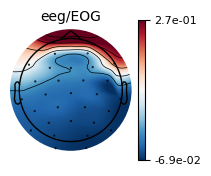

In [ ]:
# Pick EEG and EOG channels
# raw.pick_types(eeg=True, eog=True, exclude=[])

# Set EEG reference and filter data
raw.set_eeg_reference('average')
# Highpass filter to eliminate slow drifts
raw.filter(0.3, None, picks= ['eeg', 'eog'])

# Create EOG epochs
eog_epochs = create_eog_epochs(raw)  # This automatically detects EOG events
# eog_epochs.apply_baseline((0, 0))  # Baseline correction, if necessary

# Perform regression to get correction coefficients
model_plain = EOGRegression(picks="eeg", picks_artifact="eog").fit(eog_epochs)

fig = model_plain.plot()

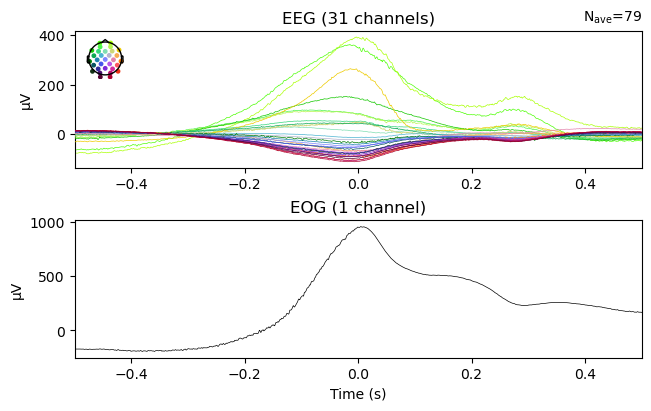

In [ ]:
# we'll try to keep a consistent ylim across figures
plot_kwargs = dict(picks=["eeg","eog"])

# plot the evoked for the EEG and the EOG sensors
fig = eog_epochs.average("all").plot(**plot_kwargs)
fig.set_size_inches(6, 6)

No projector specified for this dataset. Please consider the method self.add_proj.


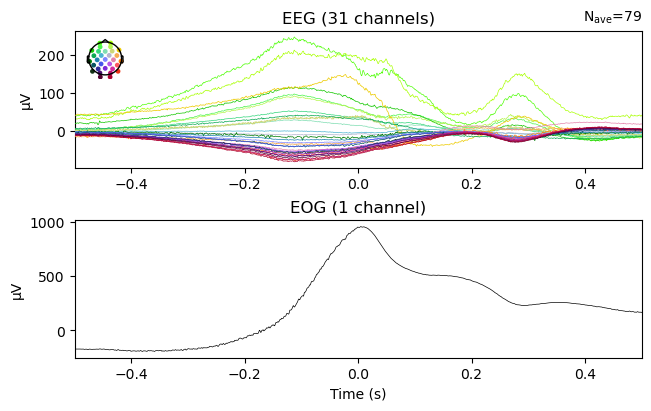

In [ ]:
epochs_clean_plain = model_plain.apply(eog_epochs)
# epochs_clean_plain.apply_baseline()
fig = epochs_clean_plain.average("all").plot(**plot_kwargs)
fig.set_size_inches(6, 6)

In [ ]:
# eog_epochs = mne.preprocessing.create_eog_epochs(raw)
# # We need to explicitly specify that we want to average the EOG channel too.
# eog_evoked = eog_epochs.average(["eeg", "eog"])
# eog_evoked.plot(["eeg", "eog"])
# fig.set_size_inches(6, 6)

# # perform regression on the evoked blink response
# model_evoked = EOGRegression(picks="eeg", picks_artifact="eog").fit(eog_evoked)
# fig = model_evoked.plot(vlim=(None, 0.4))
# fig.set_size_inches(3, 2)

# # for good measure, also show the effect on the blink evoked
# eog_evoked_clean = model_evoked.apply(eog_evoked)
# # eog_evoked_clean.apply_baseline()
# eog_evoked_clean.plot("all")
# fig.set_size_inches(6, 6)

In [ ]:
raw.plot(title='Before')
raw_clean = model_plain.apply(raw)
# raw_clean.apply_baseline()
raw_clean.plot(title='After')

No projector specified for this dataset. Please consider the method self.add_proj.


In [ ]:
# # Apply the regression to remove EOG artifacts
# raw_corrected = model.apply(raw)

# # Optionally, save the cleaned data
# # raw_corrected.save('path_to_save_cleaned_raw.fif', overwrite=True)

# # Visualize the effect
# raw.plot(title="Before EOG correction")
# raw_corrected.plot(title="After EOG correction")